#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score

from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score

#### Import split test data

In [37]:
y_test = pd.read_pickle("../../Data/y_test.pkl")
y_train = pd.read_pickle("../../Data/y_train.pkl")
X_test_ohe = pd.read_pickle("../../Data/X_test_ohe.pkl")
X_train_ohe = pd.read_pickle("../../Data/X_train_ohe.pkl")
X = pd.read_csv("../../Data/Xcols.csv")
X = np.array(X, dtype=pd.Series)

In [8]:
# From https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Evaluate vanilla model

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 20)
base_model.fit(X_train_ohe, y_train)
print('Score: ', base_model.score(X_train_ohe, y_train))

#### RandomForest Classifier

In [6]:
clf = RandomForestClassifier(n_jobs = -1)

In [7]:
clf.fit(X_train_ohe, y_train)

/opt/anaconda2/envs/p36workshop/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [8]:
clf.score(X_train_ohe, y_train)

0.9617163412127441

#### Hyperparameter tuning

Setting ranges for relevant parameters using Randomized Search

In [9]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 400, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 222, 244, 266, 288, 311, 333, 355, 377, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


#### Fitting Random Forest with Randomized Search

In [10]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 10, scoring='precision', 
                              cv = 2, verbose=2, random_state=10, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train_ohe, y_train);

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  7.5min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 10.1min finished


In [11]:
rf_random.best_params_

{'n_estimators': 244,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

In [12]:
rf_1 = RandomForestClassifier(n_estimators=244,
                              min_samples_split=5,
                              min_samples_leaf=2,
                              max_features='sqrt',
                              max_depth=60,
                              bootstrap=True)

In [13]:
rf_1.fit(X_train_ohe,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=244,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
rf_1.score(X_train_ohe, y_train)

0.8466341212744091

### Grid Search

In [15]:
n_estimators = [100, 300, 500]
max_depth = [5, 8, 15, 25, 30]
max_features = [2, 3]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

In [16]:
tuning = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

In [ ]:
grid_search = GridSearchCV(base_model, tuning, cv = 2,
                     n_jobs = -1, return_train_score=True)
grid_search.fit(X_train_ohe, y_train)

In [ ]:
#grid_search.cv_results_

In [ ]:
grid_search.best_params_

#### Random Forest using Grid Search parameters 

In [10]:
rf2 =RandomForestClassifier(max_features='auto', n_estimators= 500, max_depth=30, min_samples_leaf=1, min_samples_split=2)

In [11]:
rf2.fit(X_train_ohe, y_train)
#pred=rf2.predict(x_train_ohe)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
rf2.score(X_test_ohe,y_test)

0.82519782139554

In [15]:
importances = rf2.feature_importances_

#### Plotting feature importance 

In [52]:
features=X
importances = rf2.feature_importances_[:10]
indices = np.argsort(importances)

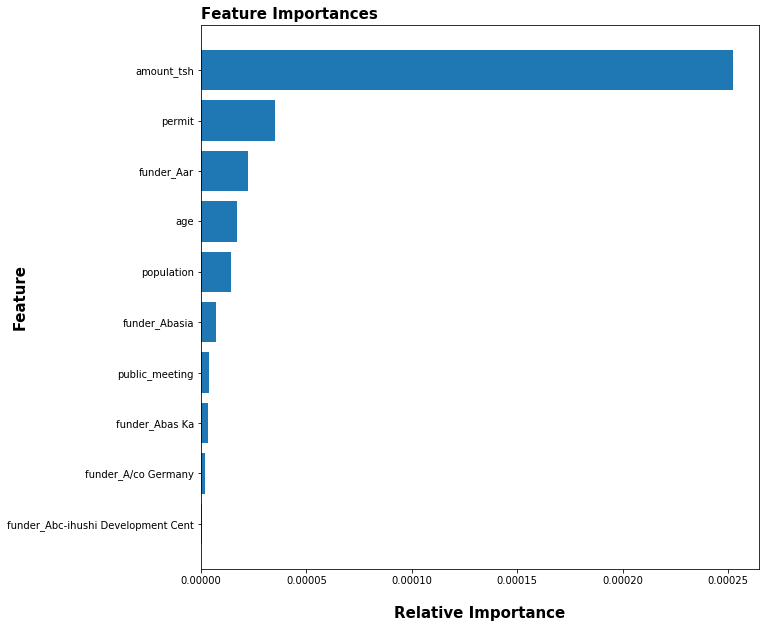

In [54]:
plt.figure(1,figsize=(10,10))
plt.title('Feature Importances',fontweight='bold',fontsize=15,loc='left')
ax1 = plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance',fontweight='bold',fontsize=15,labelpad = 20)
plt.ylabel('Feature',fontweight='bold',fontsize=15,labelpad = -20)

plt.savefig('../../images/featimportance.png',bbox_inches='tight',pad_inches=0.5)

In [ ]:
roc_auc